TODO:
* Implement early stopping
* Look and analize where models fail

## Description

The objective of this project is to test different architectures to compare two digits visible in a two-channel image. It aims at showing in particular the impact of weight sharing, and of the use of an auxiliary loss to help the training of the main objective. 
It should be implemented with PyTorch only code, in particular without using other external libraries such as scikit-learn or numpy.

The goal of this project is to implement a deep network such that, given as input a series of 2×14×14
tensor, corresponding to pairs of 14 × 14 grayscale images, it predicts for each pair if the first digit is
lesser or equal to the second.

In [1]:
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import copy

from networks import NetSimple, NetSiamese
from utils import get_accuracy, grid_search, plot_accuracy_and_loss, test_samples, test_model, plot_test_results

from dlc_practical_prologue import generate_pair_sets

## Data

The training and test set should be 1, 000 pairs each, and the size of the images allows to run
experiments rapidly, even in the VM with a single core and no GPU.
You can generate the data sets to use with the function generate_pair_sets(N) defined in the file
dlc_practical_prologue.py.

In [2]:
N = 1000

In [3]:
train_input, train_class, train_digit, test_input, test_class, test_digit = generate_pair_sets(N)

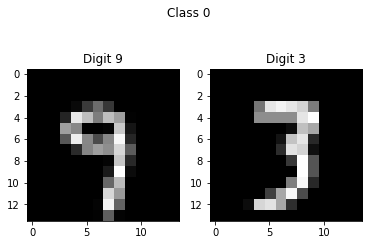

In [4]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(train_input[0][0], cmap="gray")
axs[0].set_title(f"Digit {train_digit[0][0].item()}")
axs[1].imshow(train_input[0][1], cmap="gray")
axs[1].set_title(f"Digit {train_digit[0][1].item()}")
fig.suptitle(f"Class {train_class[0].item()}")

plt.show()

In [5]:
train_loader = DataLoader(list(zip(train_input, train_class, train_digit)), batch_size=64)
test_loader = DataLoader(list(zip(test_input, test_class, test_digit)), batch_size=64)

## Objective

The goal of the project is to compare different architectures, and assess the performance improvement
that can be achieved through weight sharing, or using auxiliary losses. For the latter, the training can
in particular take advantage of the availability of the classes of the two digits in each pair, beside the
Boolean value truly of interest.

In [6]:
cross_entropy = nn.CrossEntropyLoss()
binary_cross_entropy = nn.BCEWithLogitsLoss()

## Model

In [7]:
# Task specific setup
input_channels = 2
output_class_channels = 1
output_digit_channels = 10

### Simple model

First let's implement simple model

In [8]:
net = NetSimple(input_channels, output_class_channels)

In [9]:
def simple_model_criterion(output, target):
    return binary_cross_entropy(output, target.unsqueeze(1).float())

In [10]:
from torchsummary import summary
summary(net, input_size=(2, 14, 14), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 12, 12]             608
         MaxPool2d-2             [-1, 32, 6, 6]               0
            Conv2d-3             [-1, 64, 4, 4]          18,496
         MaxPool2d-4             [-1, 64, 2, 2]               0
            Linear-5                  [-1, 100]          25,700
            Linear-6                    [-1, 1]             101
Total params: 44,905
Trainable params: 44,905
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.17
Estimated Total Size (MB): 0.23
----------------------------------------------------------------


### Model with weight sharing

Since we know that in both channels we have digits, its logical to process them in same way. For that we will use same convolution and fully connected layers. At the end we will also add 2 fully connected layers to actually solve our general task of class prediction.

In [11]:
net = NetSiamese(input_channels, output_class_channels, output_digit_channels)

In [12]:
from torchsummary import summary
summary(net, input_size=(2, 14, 14), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 12, 12]             320
         MaxPool2d-2             [-1, 32, 6, 6]               0
            Conv2d-3             [-1, 64, 4, 4]          18,496
         MaxPool2d-4             [-1, 64, 2, 2]               0
            Conv2d-5           [-1, 32, 12, 12]             320
         MaxPool2d-6             [-1, 32, 6, 6]               0
            Conv2d-7             [-1, 64, 4, 4]          18,496
         MaxPool2d-8             [-1, 64, 2, 2]               0
            Linear-9                  [-1, 100]          25,700
           Linear-10                   [-1, 10]           1,010
           Linear-11                  [-1, 100]          25,700
           Linear-12                   [-1, 10]           1,010
           Linear-13                   [-1, 50]           1,050
           Linear-14                   

In [13]:
def siamese_model_criterion(output_class, target_class):
    return binary_cross_entropy(output_class, target_class.unsqueeze(1).float())

On positive side effect of weight sharing in current setup will be that model will have double more data to train first layers. It happens because we divided each sample in our data and obtained twice more samples.

### Siamese model with auxiliary loss

In these model we will try to train model to not only predict class but also both digits. For that we will use Siamese network from previous step but also add addtional losses on intermediate fully connected layers

In [14]:
def auxiliary_loss_model_criterion(output_class, target_class, output_digits, target_digits):
    return 5 * binary_cross_entropy(output_class, target_class.unsqueeze(1).float()) \
            + cross_entropy(output_digits[0], target_digits[:, 0]) \
            + cross_entropy(output_digits[0], target_digits[:, 1])

## Training

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [16]:
device = torch.device("cpu")

In [17]:
def train(train_data_loader, test_data_loader,
          model, optimizer, criterion, device,
          epochs=10, print_info=False, print_every=5):
    """Trains model and computes accuracy on each test_every steps"""
    model.to(device)
#     optimizer.to(device)
#     criterion.to(device)
    
    losses = []
    # Accuracy of class prediction
    accuracy_train_class = []
    accuracy_test_class = []
    # Accuracy of digit precition for model with auxiliary loss
    accuracy_train_digit = []
    accuracy_test_digit = []
    # Early stopping (saving the best model among epochs)
    best_model = None
    best_accuracy = 0
    
    for epoch in range(epochs):
        loss_epoch = 0
        
        # Train
        for (image, target_class, target_digits) in train_data_loader:
            image, target_class, target_digits = image.to(device), target_class.to(device), target_digits.to(device)
            optimizer.zero_grad()
            if model.predicts_digit: # For model with auxiliary loss
                output_class, output_digits = model(image)
                loss = criterion(output_class, target_class, output_digits, target_digits)
            else:
                output_class = model(image)
                loss = criterion(output_class, target_class)
            loss.backward()
            optimizer.step()
            
            loss_epoch += loss.item()
                
        losses.append(loss_epoch)
        
        # Test
        model.eval()
        with torch.no_grad():
            accuracy_train_data = get_accuracy(model, train_data_loader, device,
                                               calculate_accuracy_digit=model.predicts_digit)
            accuracy_test_data = get_accuracy(model, test_data_loader, device,
                                              calculate_accuracy_digit=model.predicts_digit)
            if model.predicts_digit: # For model with auxiliary loss
                acc_train_class, acc_train_digit = accuracy_train_data
                acc_test_class, acc_test_digit = accuracy_test_data

                accuracy_train_digit.append(acc_train_digit)
                accuracy_test_digit.append(acc_test_digit)
            else:
                acc_train_class = accuracy_train_data
                acc_test_class = accuracy_test_data

            accuracy_train_class.append(acc_train_class)
            accuracy_test_class.append(acc_test_class)
    
        if accuracy_test_class[-1] > best_accuracy:
            best_model = copy.deepcopy(model)
            
        if print_info and (epoch + 1) % print_every == 0:
            print(f"Epoch {epoch + 1}/{epochs}, loss {losses[-1]:0.4f},",
                  f"class train/test accuracy: {accuracy_train_class[-1]}/{accuracy_test_class[-1]}",
                  f", digit train/test accuracy: {accuracy_train_digit[-1]}/{accuracy_test_digit[-1]}"
                  if accuracy_train_digit else "")
        
    return best_model, [accuracy_train_class, accuracy_test_class, accuracy_train_digit, accuracy_test_digit], losses

#### Simple net

In [18]:
epochs_grid_search = 20
epochs_train = 30

In [19]:
model_class = NetSimple
model_params = {"input_channels": input_channels, 
                "output_channels": output_class_channels}
criterion = simple_model_criterion

lr, reg = grid_search([0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001], # Learning rates
                      [0.25, 0.1, 0.05, 0.01], # Regularizations
                      train, train_loader, test_loader, device, 
                      model_class, model_params, criterion, 
                      epochs=epochs_grid_search, print_info=True)

Learning rate: 0.0500, Regularization: 0.25, Test Accuracy: 0.634
Learning rate: 0.0500, Regularization: 0.10, Test Accuracy: 0.629
Learning rate: 0.0500, Regularization: 0.05, Test Accuracy: 0.669
Learning rate: 0.0500, Regularization: 0.01, Test Accuracy: 0.694
Learning rate: 0.0100, Regularization: 0.25, Test Accuracy: 0.809
Learning rate: 0.0100, Regularization: 0.10, Test Accuracy: 0.768
Learning rate: 0.0100, Regularization: 0.05, Test Accuracy: 0.783
Learning rate: 0.0100, Regularization: 0.01, Test Accuracy: 0.740
Learning rate: 0.0050, Regularization: 0.25, Test Accuracy: 0.786
Learning rate: 0.0050, Regularization: 0.10, Test Accuracy: 0.799
Learning rate: 0.0050, Regularization: 0.05, Test Accuracy: 0.791
Learning rate: 0.0050, Regularization: 0.01, Test Accuracy: 0.811
Learning rate: 0.0010, Regularization: 0.25, Test Accuracy: 0.809
Learning rate: 0.0010, Regularization: 0.10, Test Accuracy: 0.792
Learning rate: 0.0010, Regularization: 0.05, Test Accuracy: 0.809
Learning r

In [20]:
net_simple = NetSimple(input_channels, output_class_channels)
optimizer = optim.Adam(net_simple.parameters(), lr=lr, weight_decay=reg)
criterion = simple_model_criterion

net_simple, accuracies, losses = train(train_loader, test_loader,
                                       net_simple,
                                       optimizer, 
                                       criterion,
                                       device=device,
                                       epochs=epochs_train, print_info=True)

accuracy_train_class, accuracy_test_class, _, _ = accuracies

Epoch 5/30, loss 5.3211, class train/test accuracy: 0.887/0.81 
Epoch 10/30, loss 2.3724, class train/test accuracy: 0.976/0.816 
Epoch 15/30, loss 0.9769, class train/test accuracy: 0.987/0.808 
Epoch 20/30, loss 4.9833, class train/test accuracy: 0.715/0.666 
Epoch 25/30, loss 0.6656, class train/test accuracy: 0.985/0.806 
Epoch 30/30, loss 0.7496, class train/test accuracy: 0.992/0.807 


In [21]:
net_simple_filename = "net_simple.ckpt"
torch.save(net_simple.state_dict(), net_simple_filename)

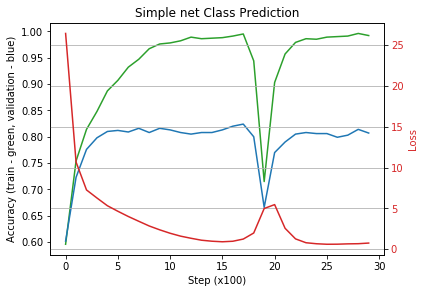

In [22]:
plot_accuracy_and_loss(accuracy_train_class, accuracy_test_class, losses, title="Simple net Class Prediction")

#### Siamese network

In [23]:
epochs_grid_search = 20
epochs_train = 30

In [24]:
model_class = NetSiamese
model_params = {"input_channels": input_channels, 
                "output_class_channels": output_class_channels, 
                "output_digit_channels": output_digit_channels}
criterion = siamese_model_criterion

lr, reg = grid_search([0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001], # Learning rates
                      [0.25, 0.1, 0.05, 0.01], # Regularizations
                      train, train_loader, test_loader, device, 
                      model_class, model_params, criterion, 
                      epochs=epochs_grid_search, print_info=True)

Learning rate: 0.0500, Regularization: 0.25, Test Accuracy: 0.526
Learning rate: 0.0500, Regularization: 0.10, Test Accuracy: 0.528
Learning rate: 0.0500, Regularization: 0.05, Test Accuracy: 0.532
Learning rate: 0.0500, Regularization: 0.01, Test Accuracy: 0.580
Learning rate: 0.0100, Regularization: 0.25, Test Accuracy: 0.817
Learning rate: 0.0100, Regularization: 0.10, Test Accuracy: 0.854
Learning rate: 0.0100, Regularization: 0.05, Test Accuracy: 0.853
Learning rate: 0.0100, Regularization: 0.01, Test Accuracy: 0.841
Learning rate: 0.0050, Regularization: 0.25, Test Accuracy: 0.828
Learning rate: 0.0050, Regularization: 0.10, Test Accuracy: 0.863
Learning rate: 0.0050, Regularization: 0.05, Test Accuracy: 0.857
Learning rate: 0.0050, Regularization: 0.01, Test Accuracy: 0.855
Learning rate: 0.0010, Regularization: 0.25, Test Accuracy: 0.867
Learning rate: 0.0010, Regularization: 0.10, Test Accuracy: 0.862
Learning rate: 0.0010, Regularization: 0.05, Test Accuracy: 0.865
Learning r

In [25]:
net_siamese = NetSiamese(input_channels, output_class_channels, output_digit_channels)
optimizer = optim.Adam(net_siamese.parameters(), lr=lr, weight_decay=reg)
criterion = siamese_model_criterion

net_siamese, accuracies, losses = train(train_loader, test_loader,
                                           net_siamese,
                                           optimizer, 
                                           criterion,
                                           device=device,
                                           epochs=epochs_train, print_info=True)

accuracy_train_class, accuracy_test_class, accuracy_train_digit, accuracy_test_digit = accuracies

Epoch 5/30, loss 3.0767, class train/test accuracy: 0.948/0.854 
Epoch 10/30, loss 1.5663, class train/test accuracy: 0.971/0.857 
Epoch 15/30, loss 0.0577, class train/test accuracy: 1.0/0.856 
Epoch 20/30, loss 0.0288, class train/test accuracy: 1.0/0.85 
Epoch 25/30, loss 0.0334, class train/test accuracy: 1.0/0.851 
Epoch 30/30, loss 0.0328, class train/test accuracy: 1.0/0.856 


In [26]:
net_siamese_loss_filename = "net_siamese_loss.ckpt"
torch.save(net_siamese.state_dict(), net_siamese_loss_filename)

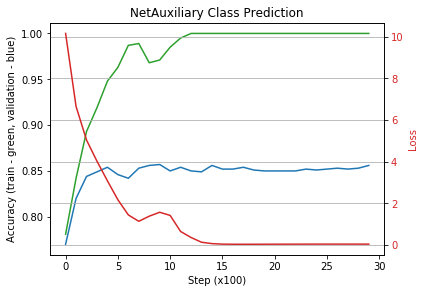

In [27]:
plot_accuracy_and_loss(accuracy_train_class, accuracy_test_class, losses, title="Siamese net Class Prediction")

#### Auxiliary loss

In [28]:
epochs_grid_search = 20
epochs_train = 30

In [31]:
model_class = NetSiamese
model_params = {"input_channels": input_channels, 
                "output_class_channels": output_class_channels, 
                "output_digit_channels": output_digit_channels,
                "auxiliary_loss": True}
criterion = auxiliary_loss_model_criterion

lr, reg = grid_search([0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001], # Learning rates
                      [0.25, 0.1, 0.05, 0.01], # Regularizations
                      train, train_loader, test_loader, device, 
                      model_class, model_params, criterion, 
                      epochs=epochs_grid_search, print_info=True)

Learning rate: 0.0500, Regularization: 0.25, Test Accuracy: 0.618
Learning rate: 0.0500, Regularization: 0.10, Test Accuracy: 0.705
Learning rate: 0.0500, Regularization: 0.05, Test Accuracy: 0.566
Learning rate: 0.0500, Regularization: 0.01, Test Accuracy: 0.768
Learning rate: 0.0100, Regularization: 0.25, Test Accuracy: 0.838
Learning rate: 0.0100, Regularization: 0.10, Test Accuracy: 0.807
Learning rate: 0.0100, Regularization: 0.05, Test Accuracy: 0.822
Learning rate: 0.0100, Regularization: 0.01, Test Accuracy: 0.802
Learning rate: 0.0050, Regularization: 0.25, Test Accuracy: 0.835
Learning rate: 0.0050, Regularization: 0.10, Test Accuracy: 0.832
Learning rate: 0.0050, Regularization: 0.05, Test Accuracy: 0.852
Learning rate: 0.0050, Regularization: 0.01, Test Accuracy: 0.842
Learning rate: 0.0010, Regularization: 0.25, Test Accuracy: 0.860
Learning rate: 0.0010, Regularization: 0.10, Test Accuracy: 0.847
Learning rate: 0.0010, Regularization: 0.05, Test Accuracy: 0.865
Learning r

In [32]:
net_auxiliary_loss = NetSiamese(input_channels, output_class_channels, output_digit_channels, auxiliary_loss=True)
optimizer = optim.Adam(net_auxiliary_loss.parameters(), lr=lr, weight_decay=reg)
criterion = auxiliary_loss_model_criterion

net_auxiliary_loss, accuracies, losses = train(train_loader, test_loader,
                                               net_auxiliary_loss,
                                               optimizer, 
                                               criterion,
                                               device=device,
                                               epochs=epochs_train, print_info=True)

accuracy_train_class, accuracy_test_class, accuracy_train_digit, accuracy_test_digit = accuracies

Epoch 5/30, loss 104.4306, class train/test accuracy: 0.791/0.759 , digit train/test accuracy: 0.7445/0.6915
Epoch 10/30, loss 68.0264, class train/test accuracy: 0.985/0.823 , digit train/test accuracy: 0.7735/0.7265
Epoch 15/30, loss 55.8586, class train/test accuracy: 0.993/0.81 , digit train/test accuracy: 0.8115/0.7505
Epoch 20/30, loss 49.9408, class train/test accuracy: 0.998/0.812 , digit train/test accuracy: 0.815/0.7795
Epoch 25/30, loss 40.6211, class train/test accuracy: 1.0/0.806 , digit train/test accuracy: 0.7945/0.7665
Epoch 30/30, loss 37.6671, class train/test accuracy: 1.0/0.808 , digit train/test accuracy: 0.761/0.7435


In [33]:
net_auxiliary_loss_filename = "net_auxiliary_loss.ckpt"
torch.save(net_auxiliary_loss.state_dict(), net_auxiliary_loss_filename)

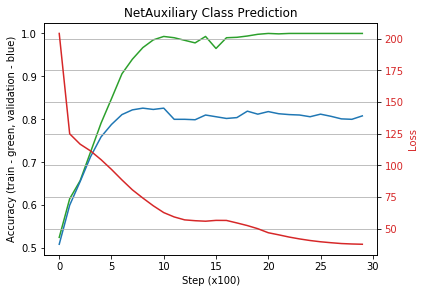

In [34]:
plot_accuracy_and_loss(accuracy_train_class, accuracy_test_class, losses, title="NetAuxiliary Class Prediction")

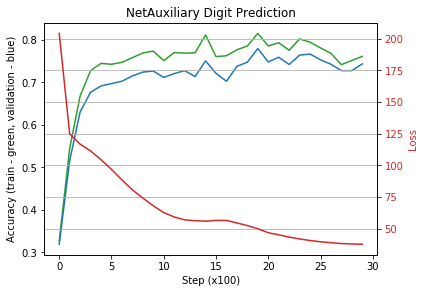

In [35]:
plot_accuracy_and_loss(accuracy_train_digit, accuracy_test_digit, losses, title="NetAuxiliary Digit Prediction")

### Test

#### Simple net

In [36]:
checkpoint = torch.load(net_simple_filename)
net_simple = NetSimple(input_channels, output_class_channels)
net_simple.load_state_dict(checkpoint)
# net_simple.to(device)

<All keys matched successfully>

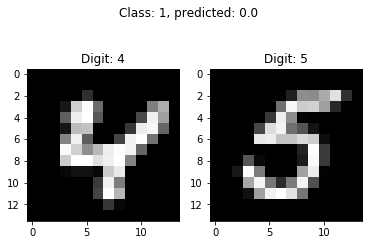

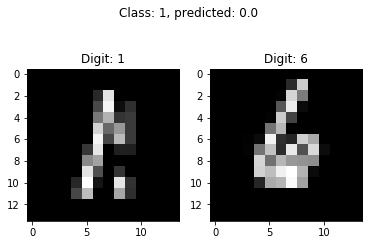

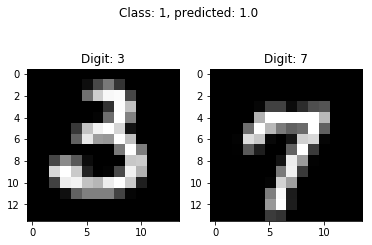

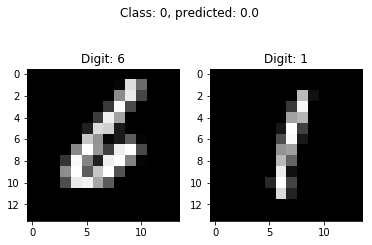

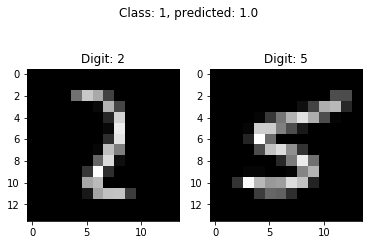

In [37]:
test_samples(net_simple, test_input, test_class, test_digit)

#### Weight sharing (Siamese network)

In [44]:
checkpoint = torch.load(net_siamese_loss_filename)
net_siamese = NetSiamese(input_channels, output_class_channels, output_digit_channels)
net_siamese.load_state_dict(checkpoint)
# net_simple.to(device)

<All keys matched successfully>

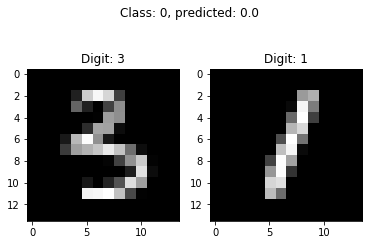

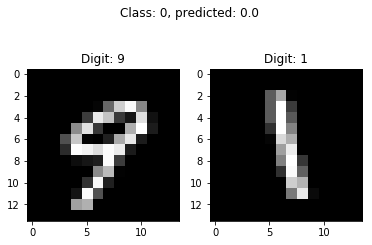

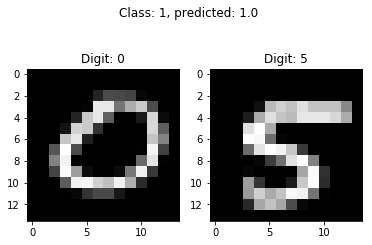

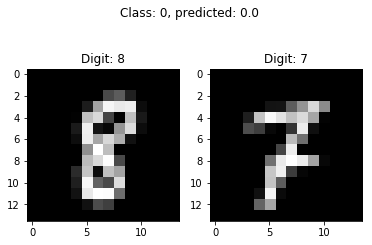

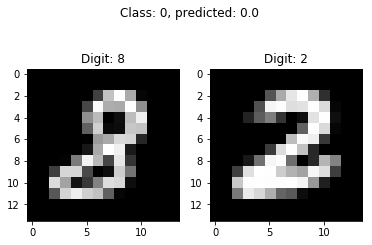

In [45]:
test_samples(net_siamese, test_input, test_class, test_digit)

#### Auxiliary loss

In [46]:
checkpoint = torch.load(net_auxiliary_loss_filename)
net_auxiliary_loss = NetSiamese(input_channels, output_class_channels, output_digit_channels, auxiliary_loss=True)
net_auxiliary_loss.load_state_dict(checkpoint)
# net_simple.to(device)

<All keys matched successfully>

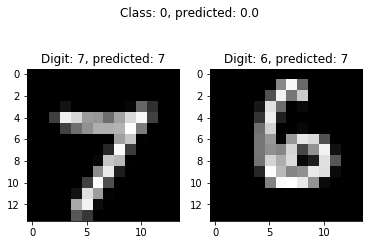

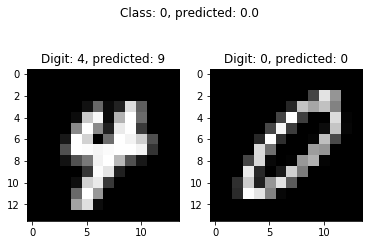

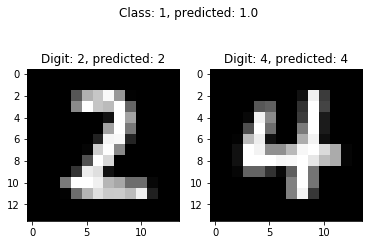

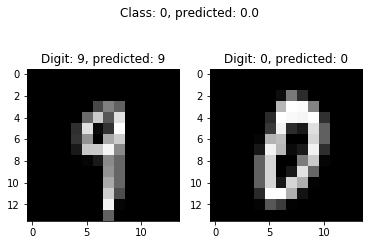

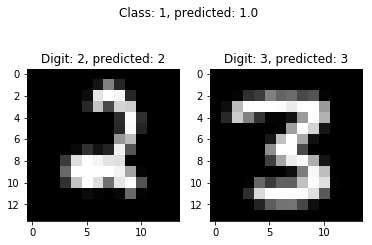

In [47]:
test_samples(net_auxiliary_loss, test_input, test_class, test_digit)

## Experiments

All the experiments should be done with 1, 000 pairs for training and test. A convnet with ∼ 70, 000
parameters can be trained with 25 epochs in the VM in less than 2s and should achieve ∼ 15% error
rate.

Performance estimates provided in your report should be estimated through 10+ rounds for each
architecture, where both data and weight initialization are randomized, and you should provide estimates
of standard deviations.

In [50]:
nb_tests = 10
epochs_train = 40

#### Simple net

In [51]:
model_class = NetSimple
model_params = {"input_channels": input_channels, 
                "output_channels": output_class_channels}
criterion = simple_model_criterion

accuracy_values, loss_values = test_model(train, train_loader, test_loader, device,
                                            model_class, model_params, criterion, lr, reg,
                                            nb_tests=nb_tests, epochs=epochs_train)

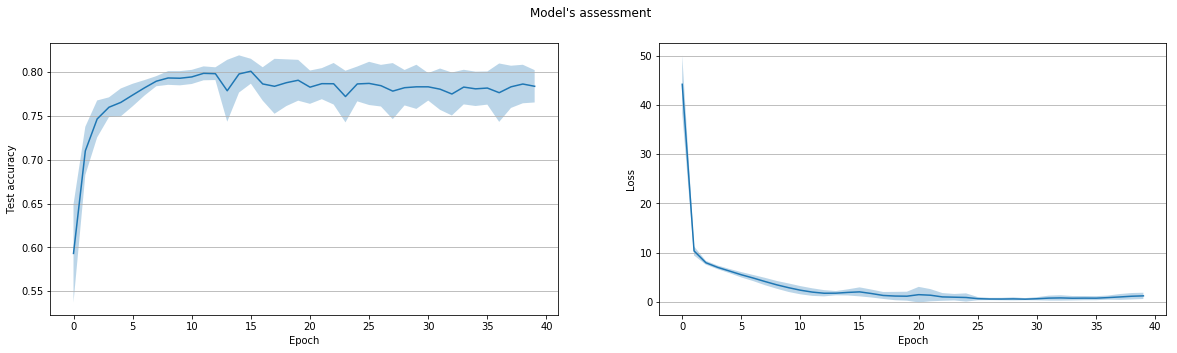

In [52]:
plot_test_results(accuracy_values, loss_values)

#### Siamese Net 

In [53]:
model_class = NetSiamese
model_params = {"input_channels": input_channels, 
                "output_class_channels": output_class_channels, 
                "output_digit_channels": output_digit_channels}
criterion = siamese_model_criterion

accuracy_values, loss_values = test_model(train, train_loader, test_loader, device,
                                            model_class, model_params, criterion, lr, reg,
                                            nb_tests=nb_tests, epochs=epochs_train)

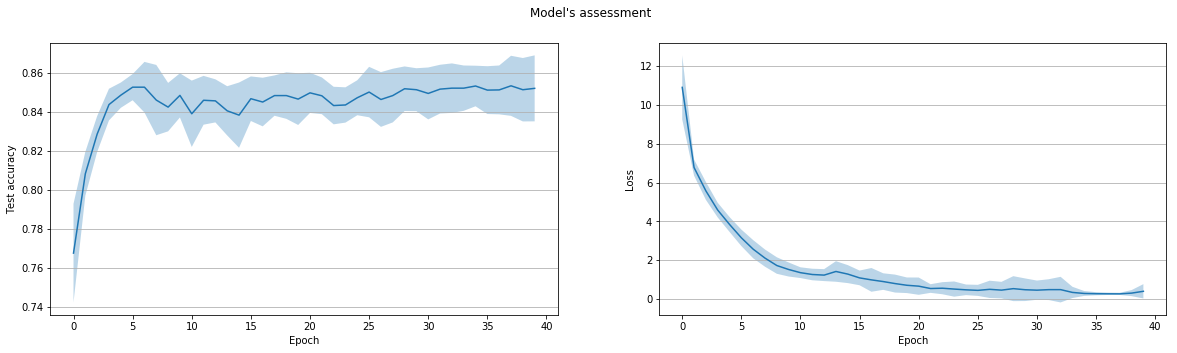

In [54]:
plot_test_results(accuracy_values, loss_values)

#### Net with AuxiliaryLoss

In [55]:
model_class = NetSiamese
model_params = {"input_channels": input_channels, 
                "output_class_channels": output_class_channels, 
                "output_digit_channels": output_digit_channels,
                "auxiliary_loss": True}
criterion = auxiliary_loss_model_criterion

accuracy_values, loss_values = test_model(train, train_loader, test_loader, device,
                                            model_class, model_params, criterion, lr, reg,
                                            nb_tests=nb_tests, epochs=epochs_train)

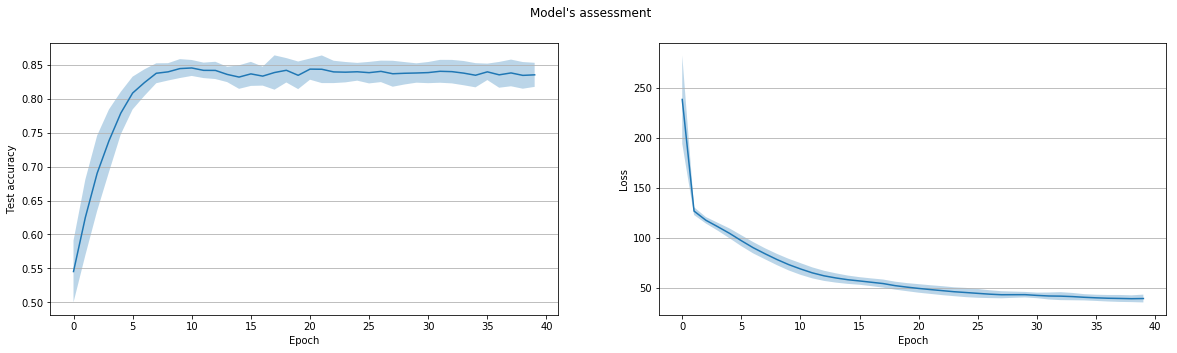

In [56]:
plot_test_results(accuracy_values, loss_values)